#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 14
**CH14A Predicting used car value: log prices**

using the used-cars dataset

version 0.9.0 2025-08-14

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import pyfixest as pf
from statsmodels.tools.eval_measures import rmse
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
# turning off scientific notation
pd.set_option("display.float_format", lambda x: "%.2f" % x)

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/used-cars/clean/"
data_out = dirname + "da_case_studies/ch14-used-cars-log/"
output = dirname + "da_case_studies/ch14-used-cars-log/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

In [3]:
# Import the prewritten helper functions
import py_helper_functions as da

# Set custom color scheme for plots
sns.set_theme(rc=da.da_theme, palette=da.color)

In [4]:
# DATA IMPORT
data = pd.read_csv(data_in + "used-cars_2cities_prep.csv")
# data = pd.read_csv("https://osf.io/7gvz9/download")

In [5]:
# SAMPLE DESIGN

# Manage missing
data["fuel"] = data["fuel"].fillna("Missing")
data["condition"] = data["condition"].fillna("Missing")
data["drive"] = data["drive"].fillna("Missing")
data["cylinders"] = data["cylinders"].fillna("Missing")
data["transmission"] = data["transmission"].fillna("Missing")
data["type"] = data["type"].fillna("Missing")

In [6]:
# Drop hybrid models then drop column
data = data.loc[data["Hybrid"] == 0].drop(columns=["Hybrid"])

# Keep gas-fuelled vehicles
data = data.loc[data["fuel"] == "gas"]

# Drop vehicles in fair and new condition
data = data.loc[~data["condition"].isin(["new", "fair"])]

# Drop unrealistic values for price and odometer reading
data = data.loc[data["price"].between(500, 25000) & (data["odometer"] <= 100)]

# Drop if price is smaller than 1000 and condition is like new or age is less than 8
data = data.loc[
    ~((data["price"] < 1000) & ((data["condition"] == "like new") | (data["age"] < 8)))
]

# Drop if transmission is manual
data = data.loc[data["transmission"] != "manual"]

# Drop if truck
data = data.loc[data["type"] != "truck"]

# Drop pricestr column
data = data.drop(columns=["pricestr"])

In [7]:
# DATA GENERATION & DESCRIPTIVES
# CONDITION
data["cond_excellent"] = np.where(data["condition"] == "excellent", 1, 0)
data["cond_good"] = np.where(data["condition"] == "good", 1, 0)
data["cond_likenew"] = np.where(data["condition"] == "like new", 1, 0)
# cylinders
data["cylind6"] = np.where(data["cylinders"] == "6 cylinders", 1, 0)
data.cylinders.value_counts()
data.cylind6.value_counts()
# age: quadratic, cubic
data["agesq"] = data["age"] ** 2
data["agecu"] = data["age"] ** 3
# odometer quadratic
data["odometersq"] = data["odometer"] ** 3

In [8]:
# focus only on Chicago
data = data.query("area=='chicago'")

### Figure 14.2 Car price, or ln car price, and age. Lowess non-parametric regressions
#### (a) Car price and age

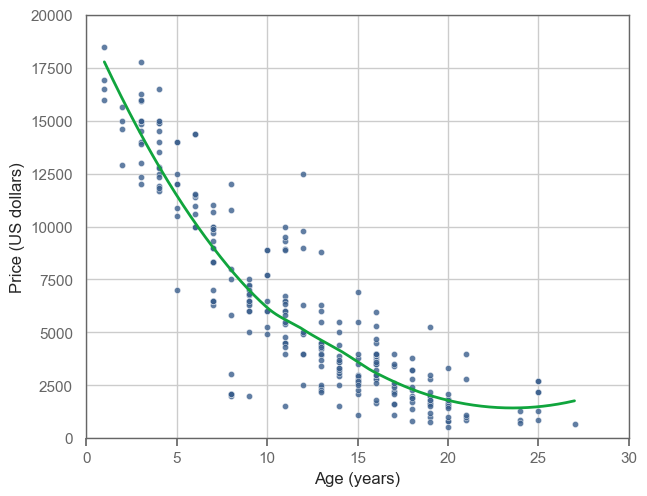

In [9]:
sns.scatterplot(data=data, x="age", y="price", s=20, alpha=0.8)
da.plot_loess(data=data, x="age", y="price", span=0.8)
plt.xlim(0, 30)
plt.ylim(0, 20000)
plt.xticks(np.arange(0, 31, 5))
plt.yticks(np.arange(0, 20001, 2500))
plt.xlabel("Age (years)")
plt.ylabel("Price (US dollars)")
plt.show()

#### (b) ln car price and age

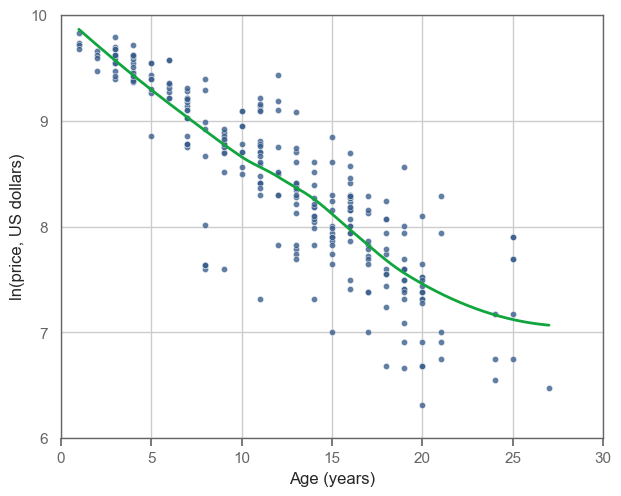

In [10]:
sns.scatterplot(data=data, x="age", y="lnprice", s=20, alpha=0.8)
da.plot_loess(data=data, x="age", y="lnprice", span=0.8)
plt.xlim(0, 30)
plt.ylim(6, 10)
plt.xticks(np.arange(0, 31, 5))
plt.yticks(range(6, 11))
plt.xlabel("Age (years)")
plt.ylabel("ln(price, US dollars)")
plt.show()

---
### Linear regressions

In [11]:
model1 = "lnprice ~ age + agesq"
model2 = "lnprice ~ age + agesq + odometer"
model3 = "lnprice ~ age + agesq + odometer + odometersq + LE + cond_excellent + cond_good + dealer"
model4 = "lnprice ~ age + agesq + odometer + odometersq + LE + XLE + SE + cond_likenew + cond_excellent + cond_good + cylind6 + dealer"
model5 = "lnprice ~ age + agesq + odometer + odometersq + LE * age + XLE * age + SE * age + cond_likenew * age + cond_excellent * age + cond_good * age + cylind6 * age + odometer * age + dealer * age"

model_equations = [model1, model2, model3, model4, model5]

In [12]:
models = []
for equation in model_equations:
    models.append(pf.feols(equation, data, vcov="HC1"))

Use custom function `ols_crossvalidator`

In [13]:
# help(da.ols_crossvalidator)

Set n_fold = 4 for 4-fold cross-validation

In [14]:
n_fold = 4

In [15]:
cv_list = []
for equation in model_equations:
    cv_list.append(da.ols_crossvalidator(equation, data, n_fold, average_rmse=False))

Get statistics for models fitted on the whole dataframe

In [16]:
(
    pd.DataFrame(cv_list)
    .round(2)
    .assign(
        RMSE=lambda x: x["RMSE"],
        BIC=lambda x: x["BIC"].astype(int),
        Coefficients=lambda x: x["Coefficients"].astype(int),
        Model=["Model " + str(i + 1) for i in range(len(model_equations))],
        Nvars=[1, 2, 5, 6, 6],
    )
    .filter(["Model", "Nvars", "Coefficients", "R-squared", "RMSE", "BIC"])
    .set_index("Model")
)

,Nvars,Coefficients,R-squared,RMSE,BIC
Model,,,,,
Model 1,1,3,0.77,0.39,288
Model 2,2,4,0.82,0.35,226
Model 3,5,9,0.83,0.34,237
Model 4,6,13,0.84,0.33,246
Model 5,6,22,0.85,0.32,275


Foldwise test RMSE-s

In [17]:
pd.DataFrame(
    [cv["Test RMSE"] for cv in cv_list],
    index=["Model " + str(i + 1) for i in range(len(cv_list))],
    columns=["Fold" + str(i + 1) for i in range(len(cv_list[0]["Test RMSE"]))],
).assign(Average=lambda x: x.mean(axis=1)).T.round(2)

,Model 1,Model 2,Model 3,Model 4,Model 5
Fold1,0.47,0.39,0.38,0.39,0.39
Fold2,0.45,0.48,0.49,0.49,0.53
Fold3,0.39,0.33,0.35,0.34,0.34
Fold4,0.34,0.30,0.30,0.29,0.31
Average,0.41,0.37,0.38,0.38,0.39


### Prediction
---

In [18]:
new = pd.DataFrame(
    pd.Series(
        {
            "age": 10,
            "agesq": 10**2,
            "odometer": 12,
            "odometersq": 12**2,
            "SE": 0,
            "LE": 1,
            "XLE": 0,
            "cond_likenew": 0,
            "cond_excellent": 1,
            "cond_good": 0,
            "dealer": 0,
            "price": np.nan,
            "cylind6": 0,
        }
    )
).T
new

,age,agesq,odometer,odometersq,SE,LE,XLE,cond_likenew,cond_excellent,cond_good,dealer,price,cylind6
0,10.00,100.00,12.00,144.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,NaN,0.00


In [19]:
reg3 = models[2]

In [ ]:
prediction_table = reg3.predict(new, interval="prediction", alpha=0.05).T.rename(
    columns={0: "Model in logs"}
)

To recalculate predictions to level, we need to extract the rmse of the fitted model

In [21]:
rmse3 = rmse(reg3.predict(data), data["lnprice"])

In [22]:
prediction_table["Recalculated to level"] = prediction_table["Model in logs"].apply(
    lambda x: np.exp(x) * np.exp(rmse3**2 / 2)
)

Add level model prediction

In [23]:
levelreg3 = pf.feols(model3.replace("ln", ""), data, vcov="HC1")

In [24]:
prediction_table["Model in levels"] = levelreg3.predict(
    new, interval="prediction", alpha=0.05
).T

### Table 14.1 Prediction with the model in log of $y$

In [25]:
prediction_table.round(2)

,Model in logs,Recalculated to level,Model in levels
fit,8.56,5524.49,5359.32
se_fit,0.07,1.14,287.16
ci_low,7.87,2770.95,2660.73
ci_high,9.25,11014.26,8057.91
